In [82]:

'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

print("keas v",keras.__version__)
print("tf v",K.tf.__version__)

num_classes = 10
gap = 10.0

keas v 1.2.2
tf v 1.0.0


In [100]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = gap
    square_pred = K.maximum(y_pred-margin/2, 0) #y_pred #K.square(y_pred)
    #square_pred = y_pred #K.square(y_pred)
    margin_square = K.maximum(margin - y_pred, 0) #K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [84]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [101]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    #for 2D view
    x = Dense(  2)(x)
    return Model(input, x)


In [102]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < gap
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < gap, y_true.dtype)))



In [103]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]


In [123]:
def create_pairs_49(x,digit_indices):
    pairs =[]
    labels=[]
    di4=digit_indices[4]
    di9=digit_indices[9]
    n = min([len(di4),len(di9)]) - 1
    print("n=",n)
    #n = 200
    #4
    for i in range(n):
        rd = random.randrange(0, n-1)
        di4a=di4[i]
        di4b=di4[rd]
        pairs+=[[x[di4a],x[di4b]]]
        di9b=di9[i]
        pairs+=[[x[di4a],x[di9b]]]
        labels+=[1,0]
    #9
    for i in range(n):
        rd = random.randrange(0, n-1)
        di9a=di9[i]
        di9b=di9[rd]
        pairs+=[[x[di9a],x[di9b]]]
        di4b=di4[i]
        pairs+=[[x[di9a],x[di4b]]]
        labels+=[1,0]
    return np.array(pairs),np.array(labels)
             
# create training+test positive and negative pairs
classes=range(10)
#digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
digit_indices = [np.where(y_train == i)[0] for i in classes]
for i,di in enumerate(digit_indices):
    print(i,len(di))
print ("-----")
tr_pairs, tr_y = create_pairs_49(x_train, digit_indices)
print(tr_pairs.shape)

#digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
digit_indices = [np.where(y_test == i)[0] for i in classes]
te_pairs, te_y = create_pairs_49(x_test, digit_indices)



0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949
-----
n= 5841
(23364, 2, 28, 28)
n= 981


In [105]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [106]:
# train
batch_size=23364
epochs = 25
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [127]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          nb_epoch=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 23364 samples, validate on 3924 samples
Epoch 1/50
23364/23364 [==============================] - 0s - loss: 0.0147 - accuracy: 0.9968 - val_loss: 0.1380 - val_accuracy: 0.9776

In [128]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.96%
* Accuracy on test set: 98.11%


(10000, 28, 28) (10000,)
(1996, 28, 28)
(1996,)


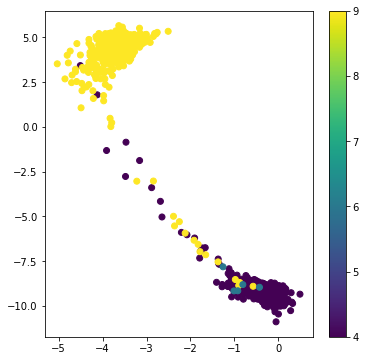

In [129]:
batch_size=128
samples=1987
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
print (x_test.shape,y_test.shape)
xt =np.vstack( (x_test[digit_indices[4][:samples]],x_test[digit_indices[9][:samples]],x_test[digit_indices[6][:5]]) )
print(xt.shape)
yt =np.concatenate( (y_test[digit_indices[4][:samples]],y_test[digit_indices[9][:samples]],y_test[digit_indices[6][:5]]) )
print(yt.shape)
x_test_encoded = encoder.predict(xt[:], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=yt[:])
plt.colorbar()
plt.show()